In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *

from activation_maximization import showall, getAM

from keras import backend as K

import cv2

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
k = 10 # Top 10% highest l2-magnitude filters

In [4]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)

a_count= []
s_count= []

full_a_a = []
full_a_s = []
full_s_a = []
full_s_s = []

l_num = 2
l = conv_layers[l_num]

print(f" ============ LAYER {l_num} , {l.name}==================")
top10F=topKfilters(model,l_num, k=k)
print(l_num, top10F)
filters = get_filter(model, l_num)[:,:,:, top10F]
s, a = getSymAntiSymTF(filters)
a_e = reduce_euclidean_norm(a, axis=[0,1])**2
#print(a_mag.shape)

s_e = reduce_euclidean_norm(s, axis=[0,1])**2
beta = tf.reduce_mean(a_e/(s_e+a_e), axis=0)


antisym_filters = tf.reshape(tf.where(beta >= 0.5), [-1])
sym_filters = tf.reshape(tf.where(beta < 0.5), [-1])

a_count.append(len(antisym_filters))
s_count.append(len(sym_filters))

#print(antisym_filters)

'''a_mag = reduce_euclidean_norm(a, axis=[0,1, 2])**2
a_mag = a_mag[top10F]
s_mag = reduce_euclidean_norm(s, axis=[0,1, 2])**2
s_mag = s_mag[top10F]'''

a_a = 0
a_s = 0
s_a = 0
s_s = 0

prv_top10KF = topKfilters(model, l_num-1, k=k)
prv_filters = get_filter(model, l_num-1)[:,:,:, prv_top10KF]
prv_s, prv_a = getSymAntiSymTF(prv_filters)
prv_a_mag = reduce_euclidean_norm(prv_a, axis=[0,1])**2
prv_s_mag = reduce_euclidean_norm(prv_s, axis=[0,1])**2
prv_avg_amag = reduce_mean(prv_a_mag, axis=0).numpy()
prv_avg_smag = reduce_mean(prv_s_mag, axis=0).numpy()
prv_beta = reduce_mean(prv_a_mag/(prv_a_mag+prv_s_mag), axis=0).numpy()
prv_antisym_filters = list(np.array(topKfilters(model, l_num-1, k=100))[[tf.reshape(tf.where(prv_beta >= 0.5), (-1))]])
prv_sym_filters = list(np.array(topKfilters(model, l_num-1, k=100))[[tf.reshape(tf.where(prv_beta < 0.5), (-1))]])
for i, idx in enumerate([17]) :
    #print("Filter ", idx , " : ", topKchannels(l_num+1,idx),"--->",set(topKchannels(l_num+1,idx)).intersection(top10F))
    #Is this filter symetric or antisymmetric ?
    is_anti = beta[i] >= 0.5
    print(is_anti)
    #print()
    # Out of its top-k connections, how many inputs are comming from sym-filters, 
    #                               how many inputs are comming from antisym-filters?

    top_k_connections = list(set(topKchannels(model,l_num,idx, k=k)).intersection(prv_top10KF))
    print("TKC",top_k_connections)
    #Check : does top_k_connections lie in antisym_filters or in sym_filters (or neither) ?  
    #print (top_k_connections, antisym_filters.shape)
    #print(tf.squeeze(antisym_filters) )

    #print("HERE" , set(tf.squeeze(antisym_filters).numpy()).intersection(set(top_k_connections)))
    #print("HERE" , set(tf.squeeze(sym_filters).numpy()).intersection(set(top_k_connections)))
    if is_anti: 
        a_a += len(list(set(prv_antisym_filters).intersection(set(top_k_connections))))
        print(idx, "Anti -> Anti : ", list(set(prv_antisym_filters).intersection(set(top_k_connections))))
        s_a += len(list(set(prv_sym_filters).intersection(set(top_k_connections))))
        print(idx,"Sym -> Anti : ", list(set(prv_sym_filters).intersection(set(top_k_connections))))

    else:
        a_s += len(list(set((prv_antisym_filters)).intersection(set(top_k_connections))))
        print(idx, "Anti -> Sym : ", list(set((prv_antisym_filters)).intersection(set(top_k_connections))))
        s_s += len(list(set((prv_sym_filters)).intersection(set(top_k_connections))))
        print(idx, "Sym ->  Sym : ", list(set((prv_sym_filters)).intersection(set(top_k_connections))))

num_connections = a_a+a_s+s_a+s_s
full_a_a.append(a_a/num_connections)
full_a_s.append(a_s/num_connections)
full_s_a.append(s_a/num_connections)
full_s_s.append(s_s/num_connections)

print("A -> A ",  a_a)
print("A -> S ",  a_s)
print("S -> A ",  s_a)
print("S -> S ",  s_s)
print(top_k_connections)




 ============ LAYER 2 , block2_conv1==================
2 [3, 12, 32, 114, 56, 70, 102, 107, 54, 80, 86, 65]


c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


tf.Tensor(True, shape=(), dtype=bool)
TKC [19, 29]
17 Anti -> Anti :  [19, 29]
17 Sym -> Anti :  []
A -> A  2
A -> S  0
S -> A  0
S -> S  0
[19, 29]


In [5]:
def plotAntiPlane(model, layer, f_num, ax, plot=None):

	ax.set_facecolor("#E5E5E5")
	#ax.set_edgecolor("white")
	conv_layers = []
	filters = get_filter(model, layer)

	theta = getSobelTF(filters)
	print(filters.shape)
	s, a = getSymAntiSymTF(filters)
	a_mag = reduce_euclidean_norm(a, axis=[0,1]).numpy()
	s_mag = reduce_euclidean_norm(s, axis=[0,1]).numpy()

	mag = reduce_euclidean_norm(filters, axis=[0,1]).numpy()

	#x =a_mag[:,f_num]*np.cos((theta[:,f_num]))
	#y = a_mag[:,f_num]*np.sin((theta[:,f_num]))


	x =(a_mag[:,f_num]*np.cos((theta[:,f_num])))
	y =( a_mag[:,f_num]*np.sin((theta[:,f_num])))
	print("X", x.shape)
	print("PLOT", plot)


	print("X", x)

	lim =np.max(np.abs(mag[:, f_num]))    
	lim*= 1.1

	cov = np.cov([x,y])
	print("COV", cov)
	e_val, e_vec = np.linalg.eig(cov)
	e_vec = e_vec[:, np.argmax(e_val)]
	e_val = np.max(e_val)
	if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
		e_vec *= -1
	#print(e_val, e_vec)

	#ax = fig.add_subplot(gs1[l_num,i])
	ax.set_xlim(-lim, lim)
	ax.set_ylim(-lim, lim)
	beta = np.mean((a_mag[:,f_num]**2)/(mag[:,f_num]**2))
	if plot is not None:
		x = x[plot]
		y = y[plot]
		beta =  np.mean((a_mag[plot,f_num]**2)/(mag[plot,f_num]**2))
	print("X", x.shape)

	ax.scatter(x,y, s=30, color='#E24A33')
	ax.set_box_aspect(1)

	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_aspect('equal')
	ax.collections[0].set_rasterized(True)

	#ax.arrow(0, 0, e_vec[0]/lim, e_vec[1]/lim, color="black", linestyle="--")
	#ax.arrow(0, 0, e_vec[0]*e_val*5, e_vec[1]*e_val*5, color="black", linestyle="--")
	ax.annotate("", xy=(e_vec[0]*e_val, e_vec[1]*e_val), xytext=(0, 0), 
				arrowprops=dict(arrowstyle="->",  color='black', lw=None))
	
	print(f_num,  np.arctan2(e_vec[1], e_vec[0]))
 
	return beta, np.arctan2(e_vec[1], e_vec[0])


Topk [100  42  10  12  14 113  81  55  56 125]
[ 56  55 125 113  81 100  42  14  10  12]
(3, 3, 128, 256)
X (128,)
PLOT [ 56  55 125 113  81]
X [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.16541173  0.27511185  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.       

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


(3, 3, 128, 128)
X (128,)
PLOT None
X [-1.91598304e-03  2.63662776e-03 -7.14325206e-03  3.23839560e-02
 -3.12482640e-02  7.25619821e-03  1.10660363e-02  1.89792905e-02
  6.13538036e-03 -1.61020886e-02 -3.42842803e-04  1.88895129e-02
 -1.85160134e-02 -9.01162252e-03 -1.14515675e-02  1.54986940e-02
  1.68480687e-02 -1.31220045e-02  2.15980038e-02  2.17616186e-03
  6.93218084e-03 -2.18111798e-02  1.84488520e-02  4.31086984e-04
 -8.36284179e-03 -6.90061320e-03  2.30027568e-02  8.18461087e-03
  4.43913089e-03  1.27274822e-02  1.69387963e-02  1.72732305e-03
  1.06751528e-02 -1.28118359e-02  4.69492413e-02 -6.70525758e-03
 -2.32951362e-02  6.83636777e-03  8.73726513e-03  1.78176668e-02
 -3.03740893e-03  1.81438234e-02  3.59501541e-02 -2.57083098e-03
 -5.65046724e-03 -4.10414860e-02 -2.97334208e-03 -5.14695458e-02
  1.20810792e-02 -5.63020492e-03  5.71562769e-03 -3.59381968e-03
  4.92774229e-03 -4.28067433e-05 -2.51517482e-02 -1.61506906e-02
 -6.25239965e-03  1.16583509e-02 -1.51266798e-03 -1.

CompletedProcess(args=['pdflatex', 'figures/AM_4_252/diagram_4_252.tex'], returncode=0)

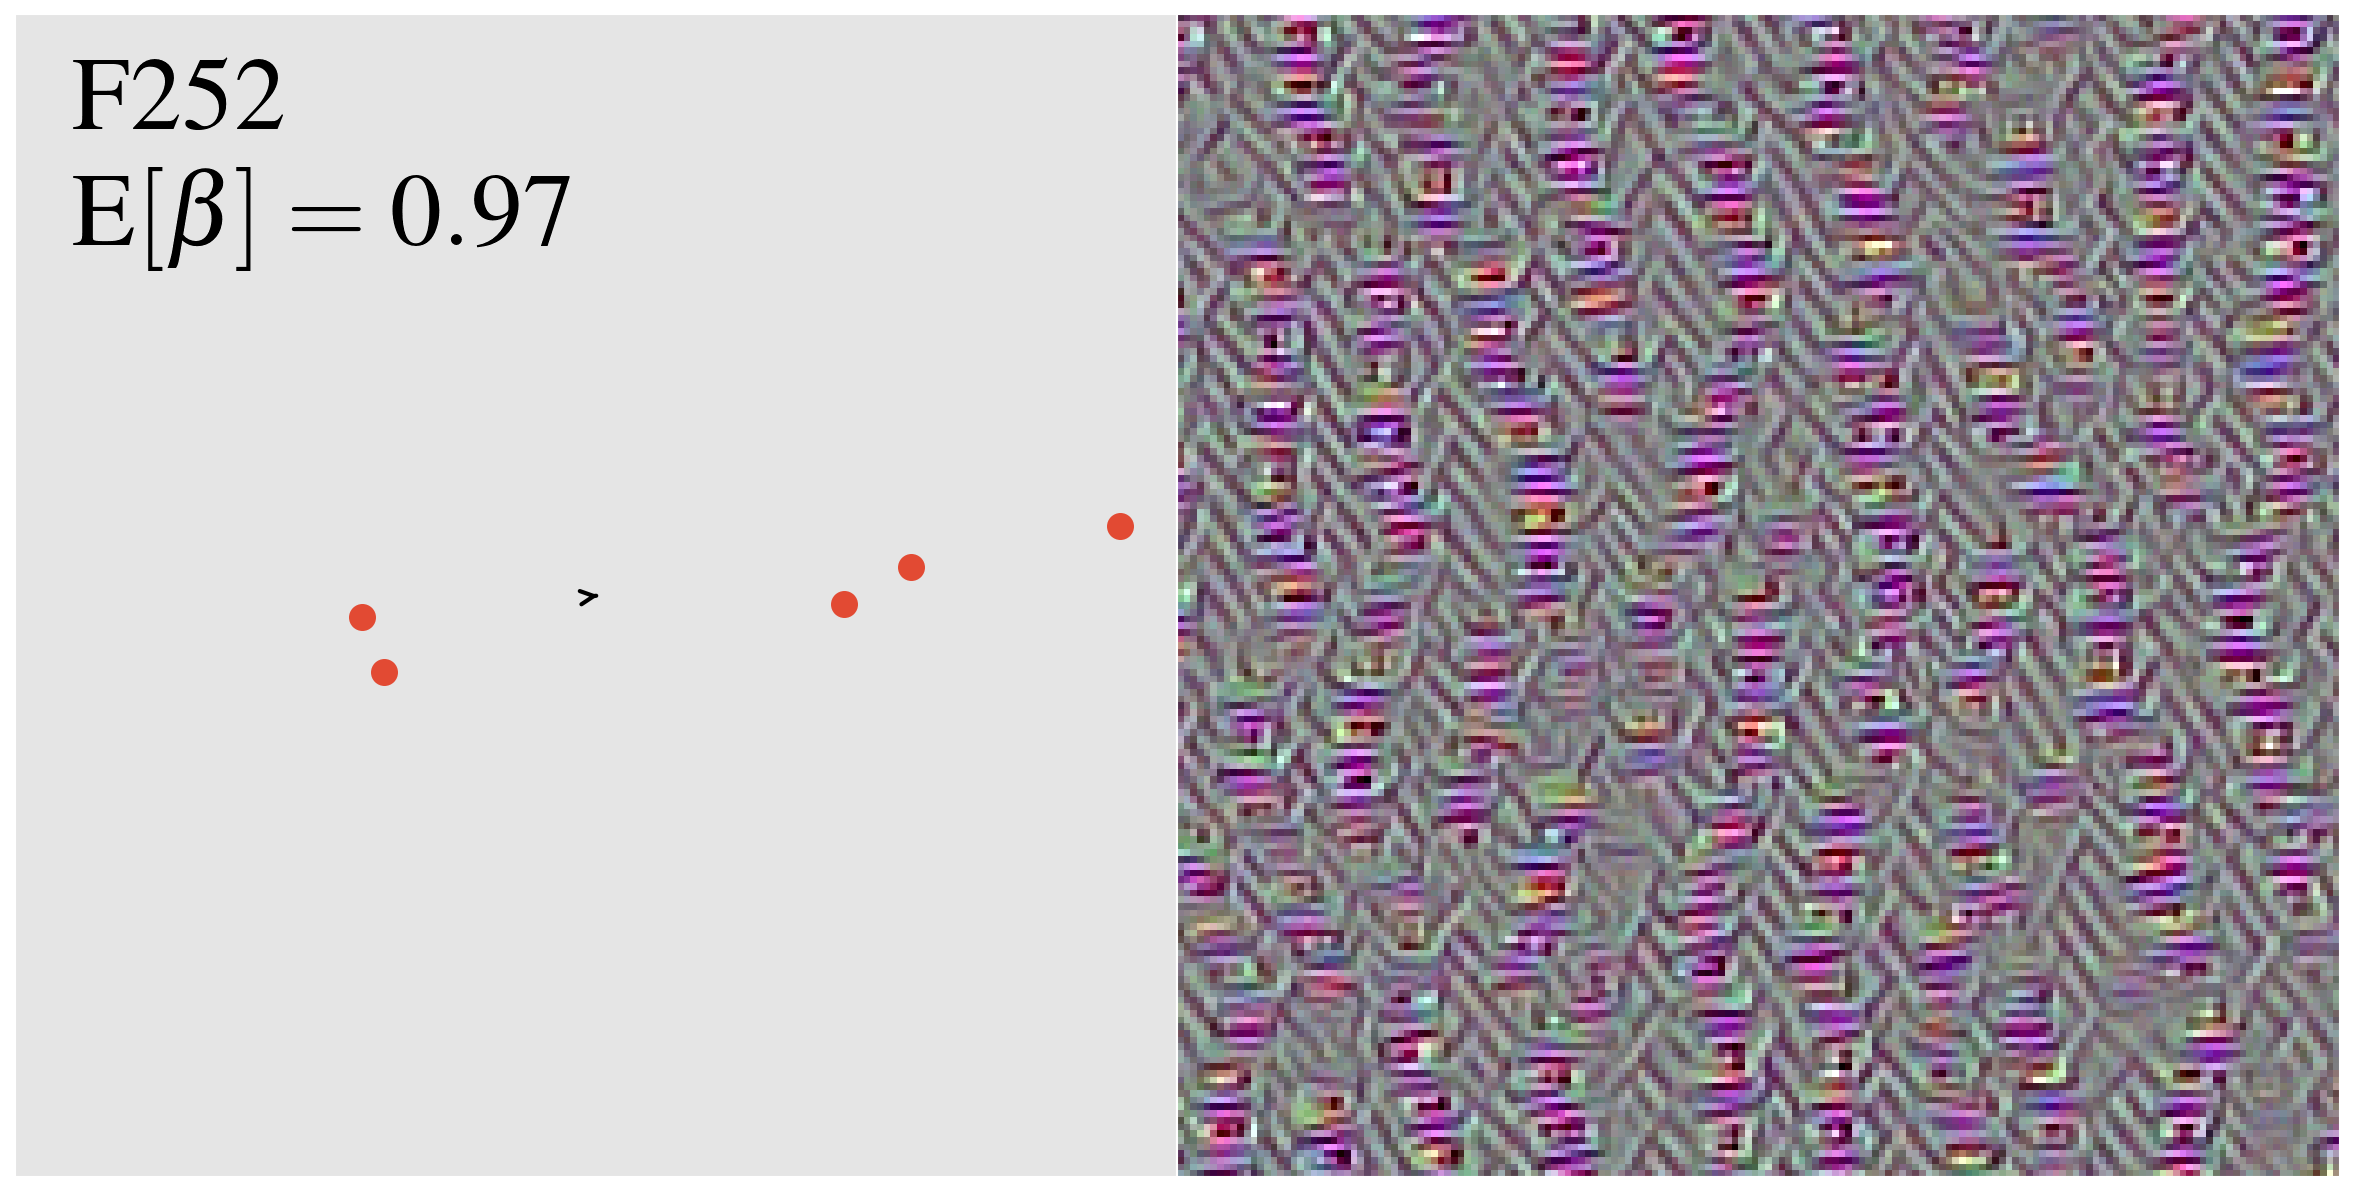

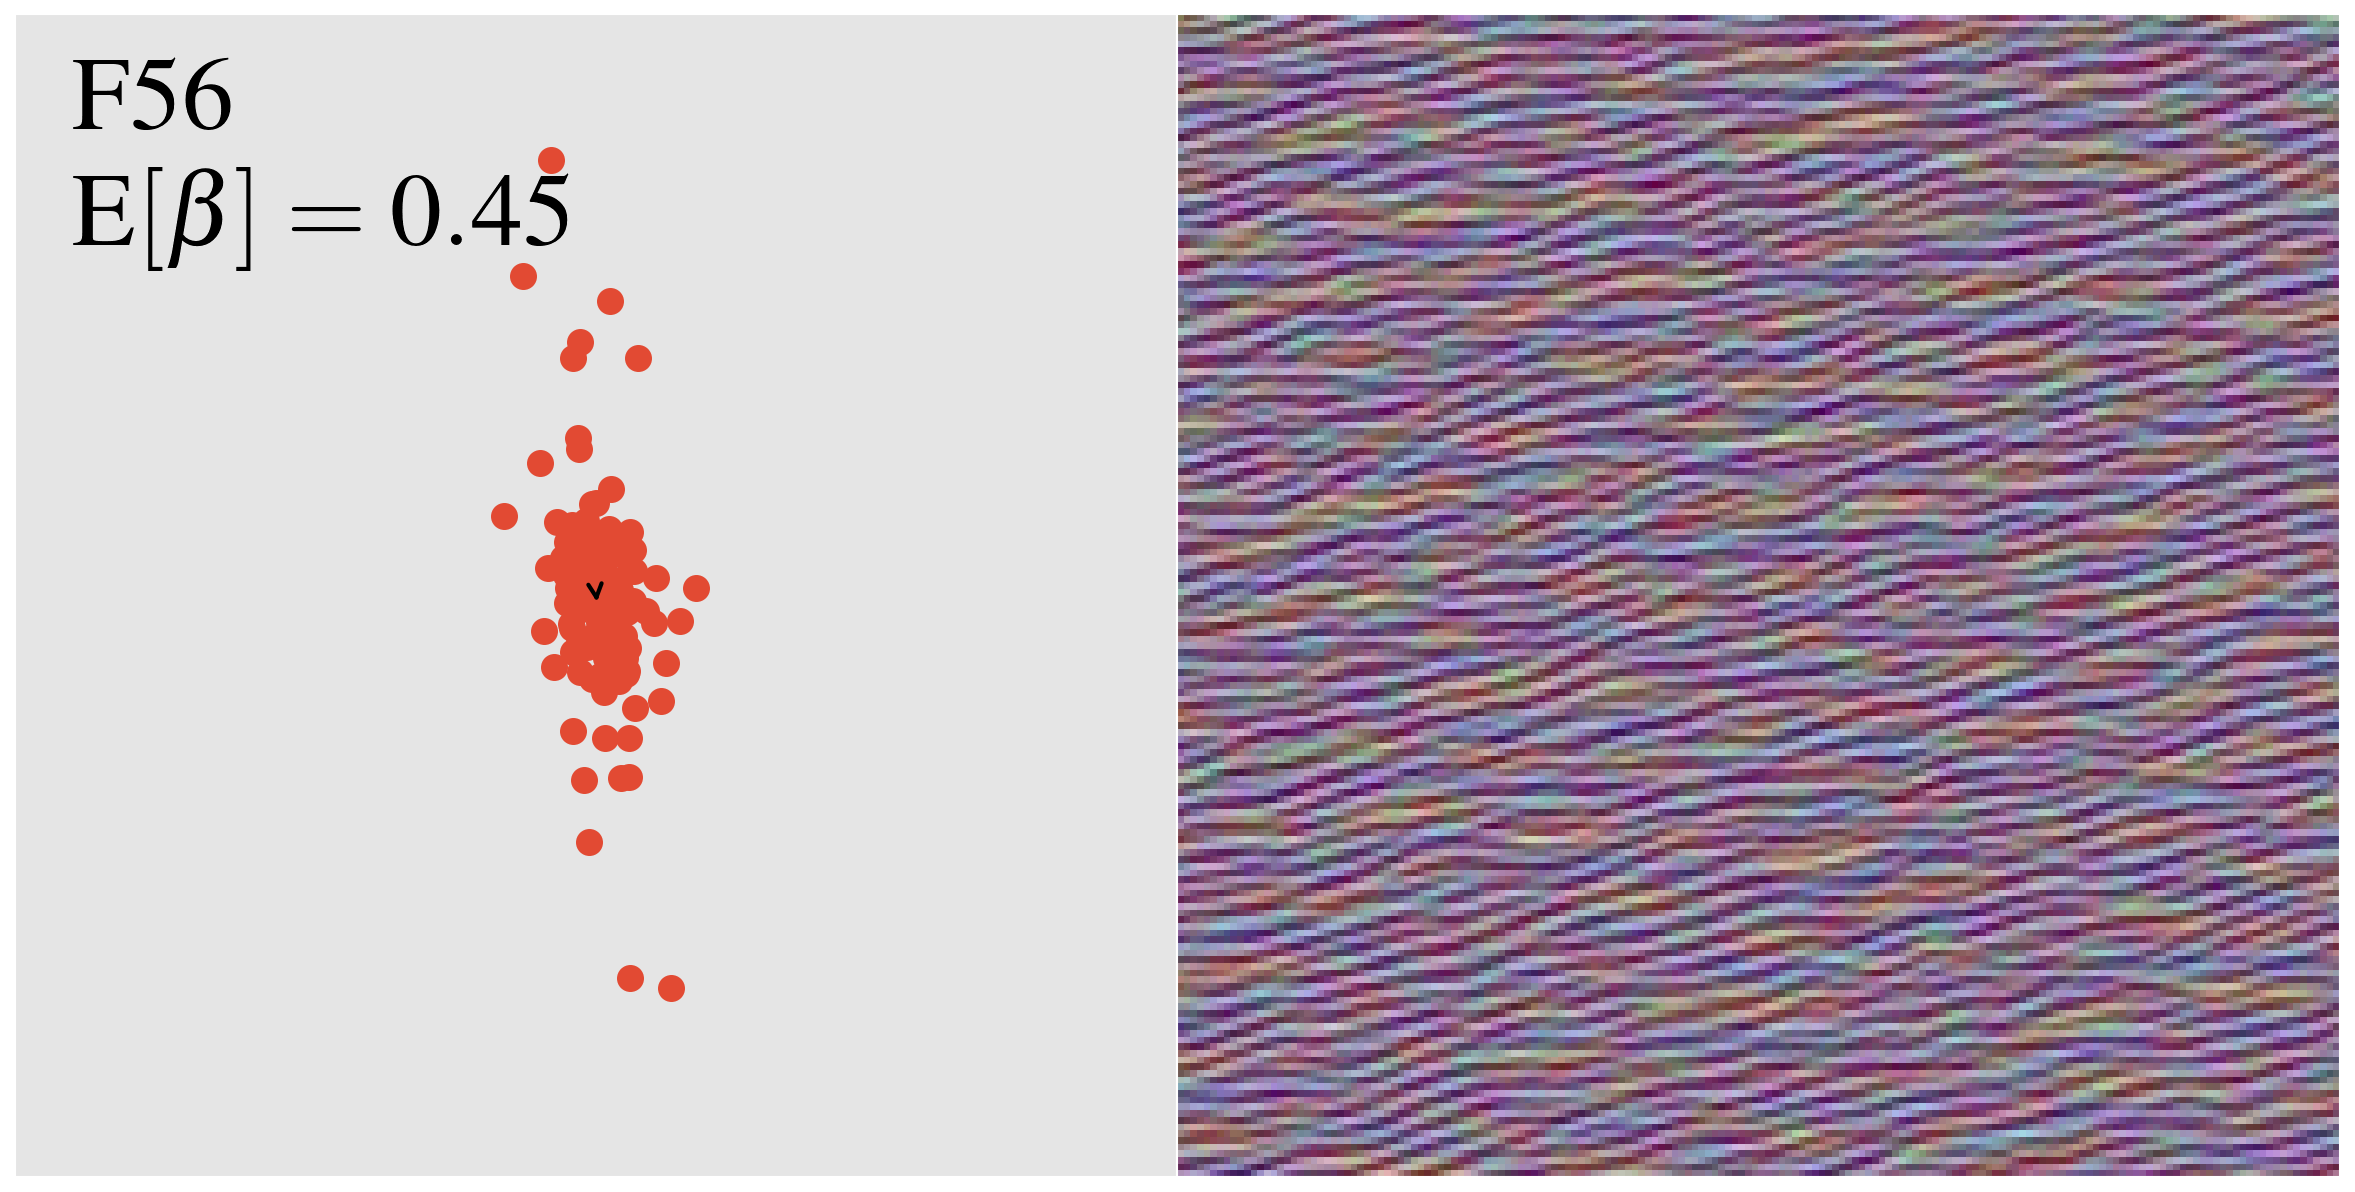

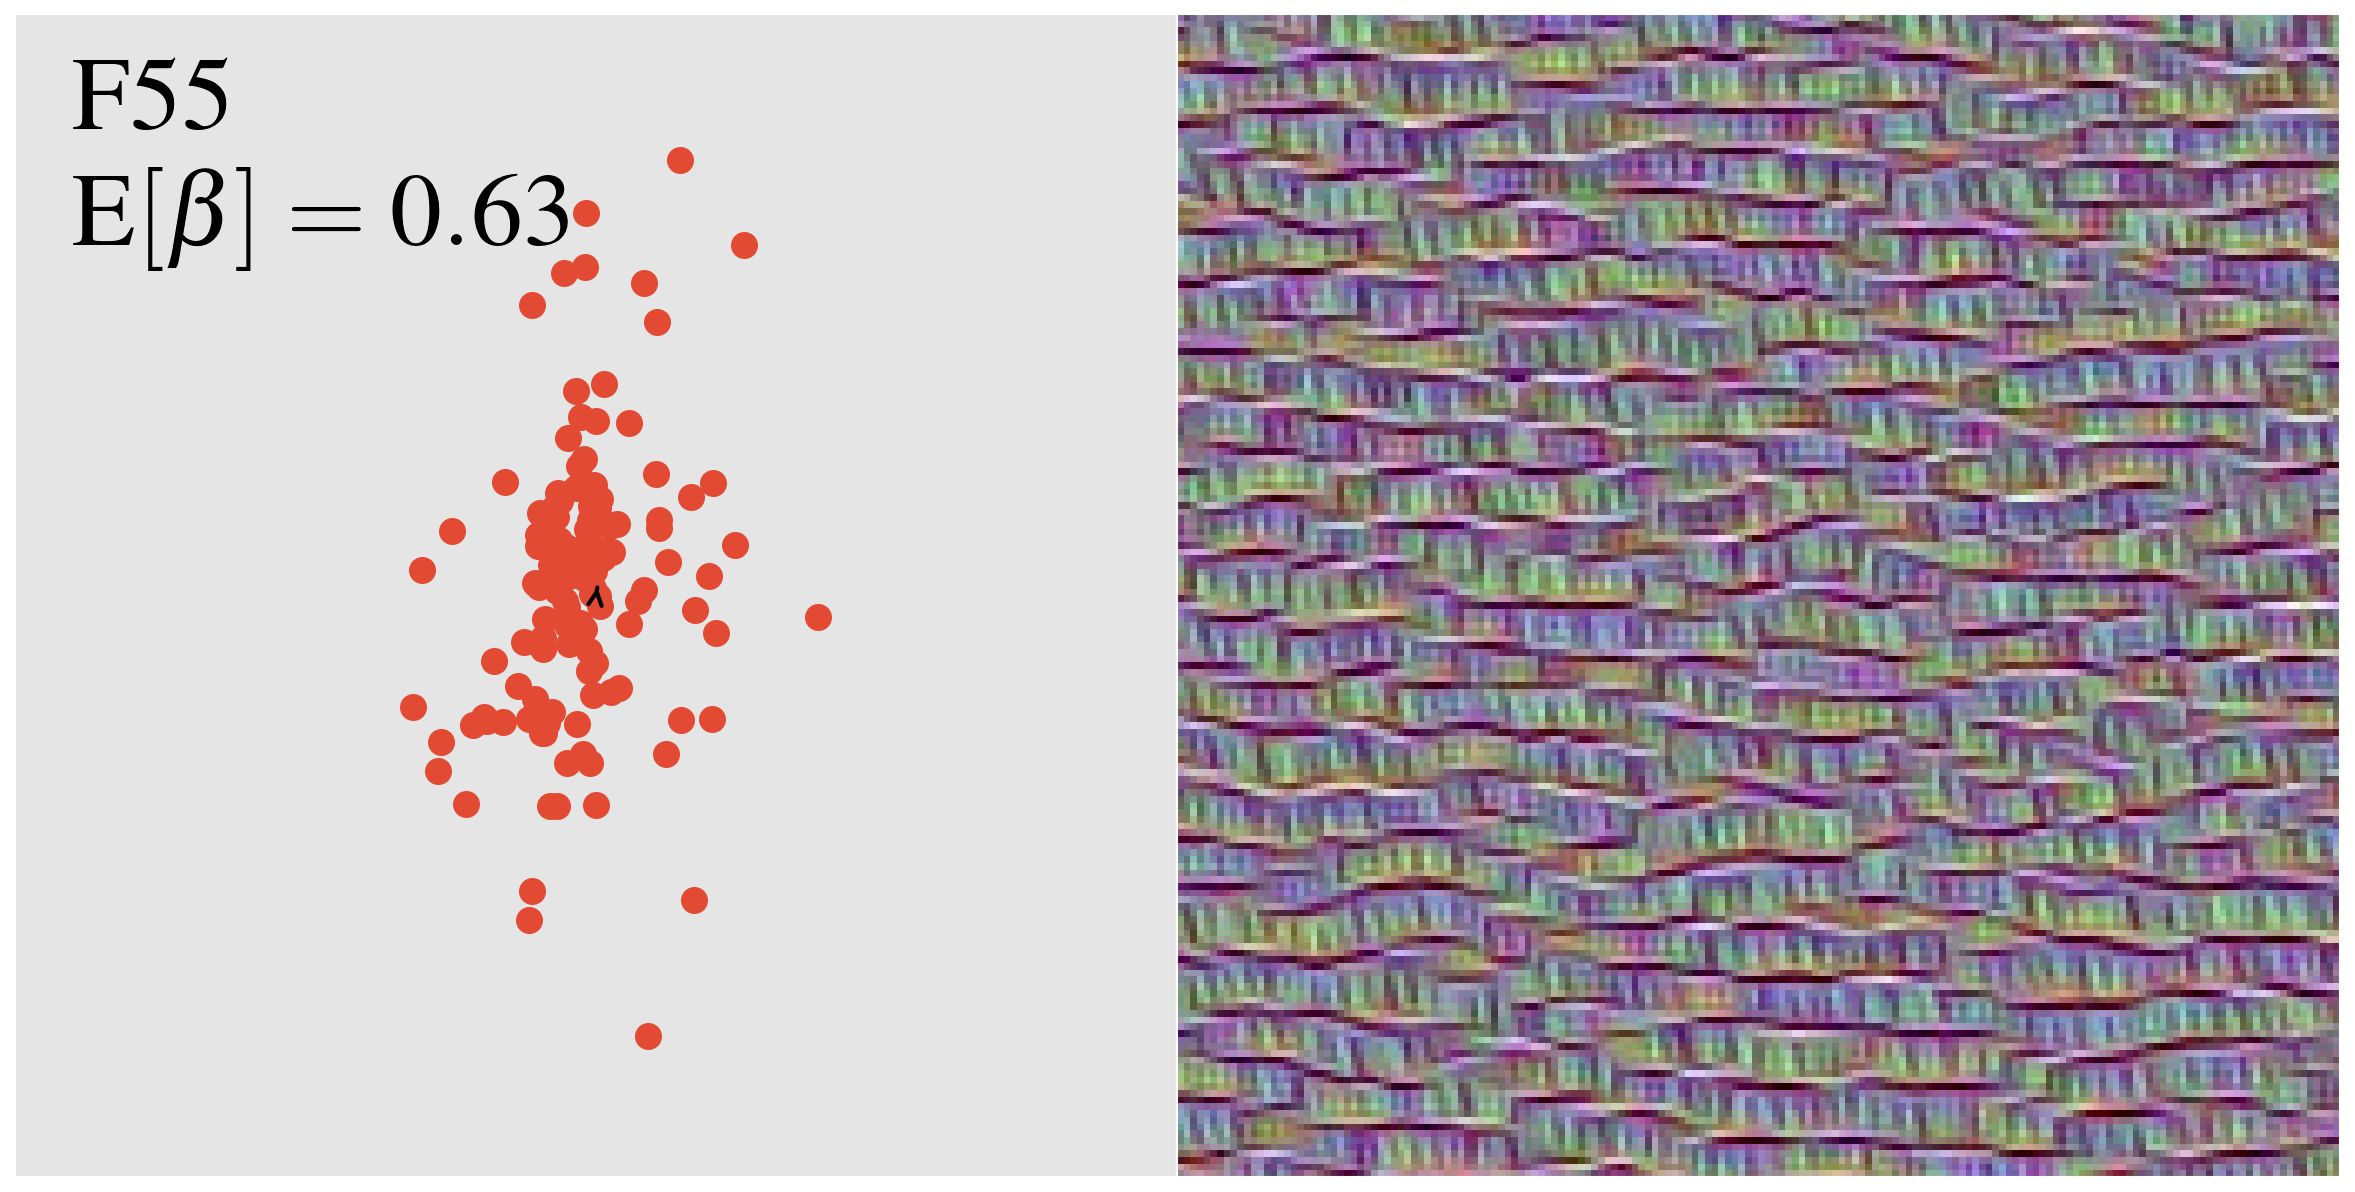

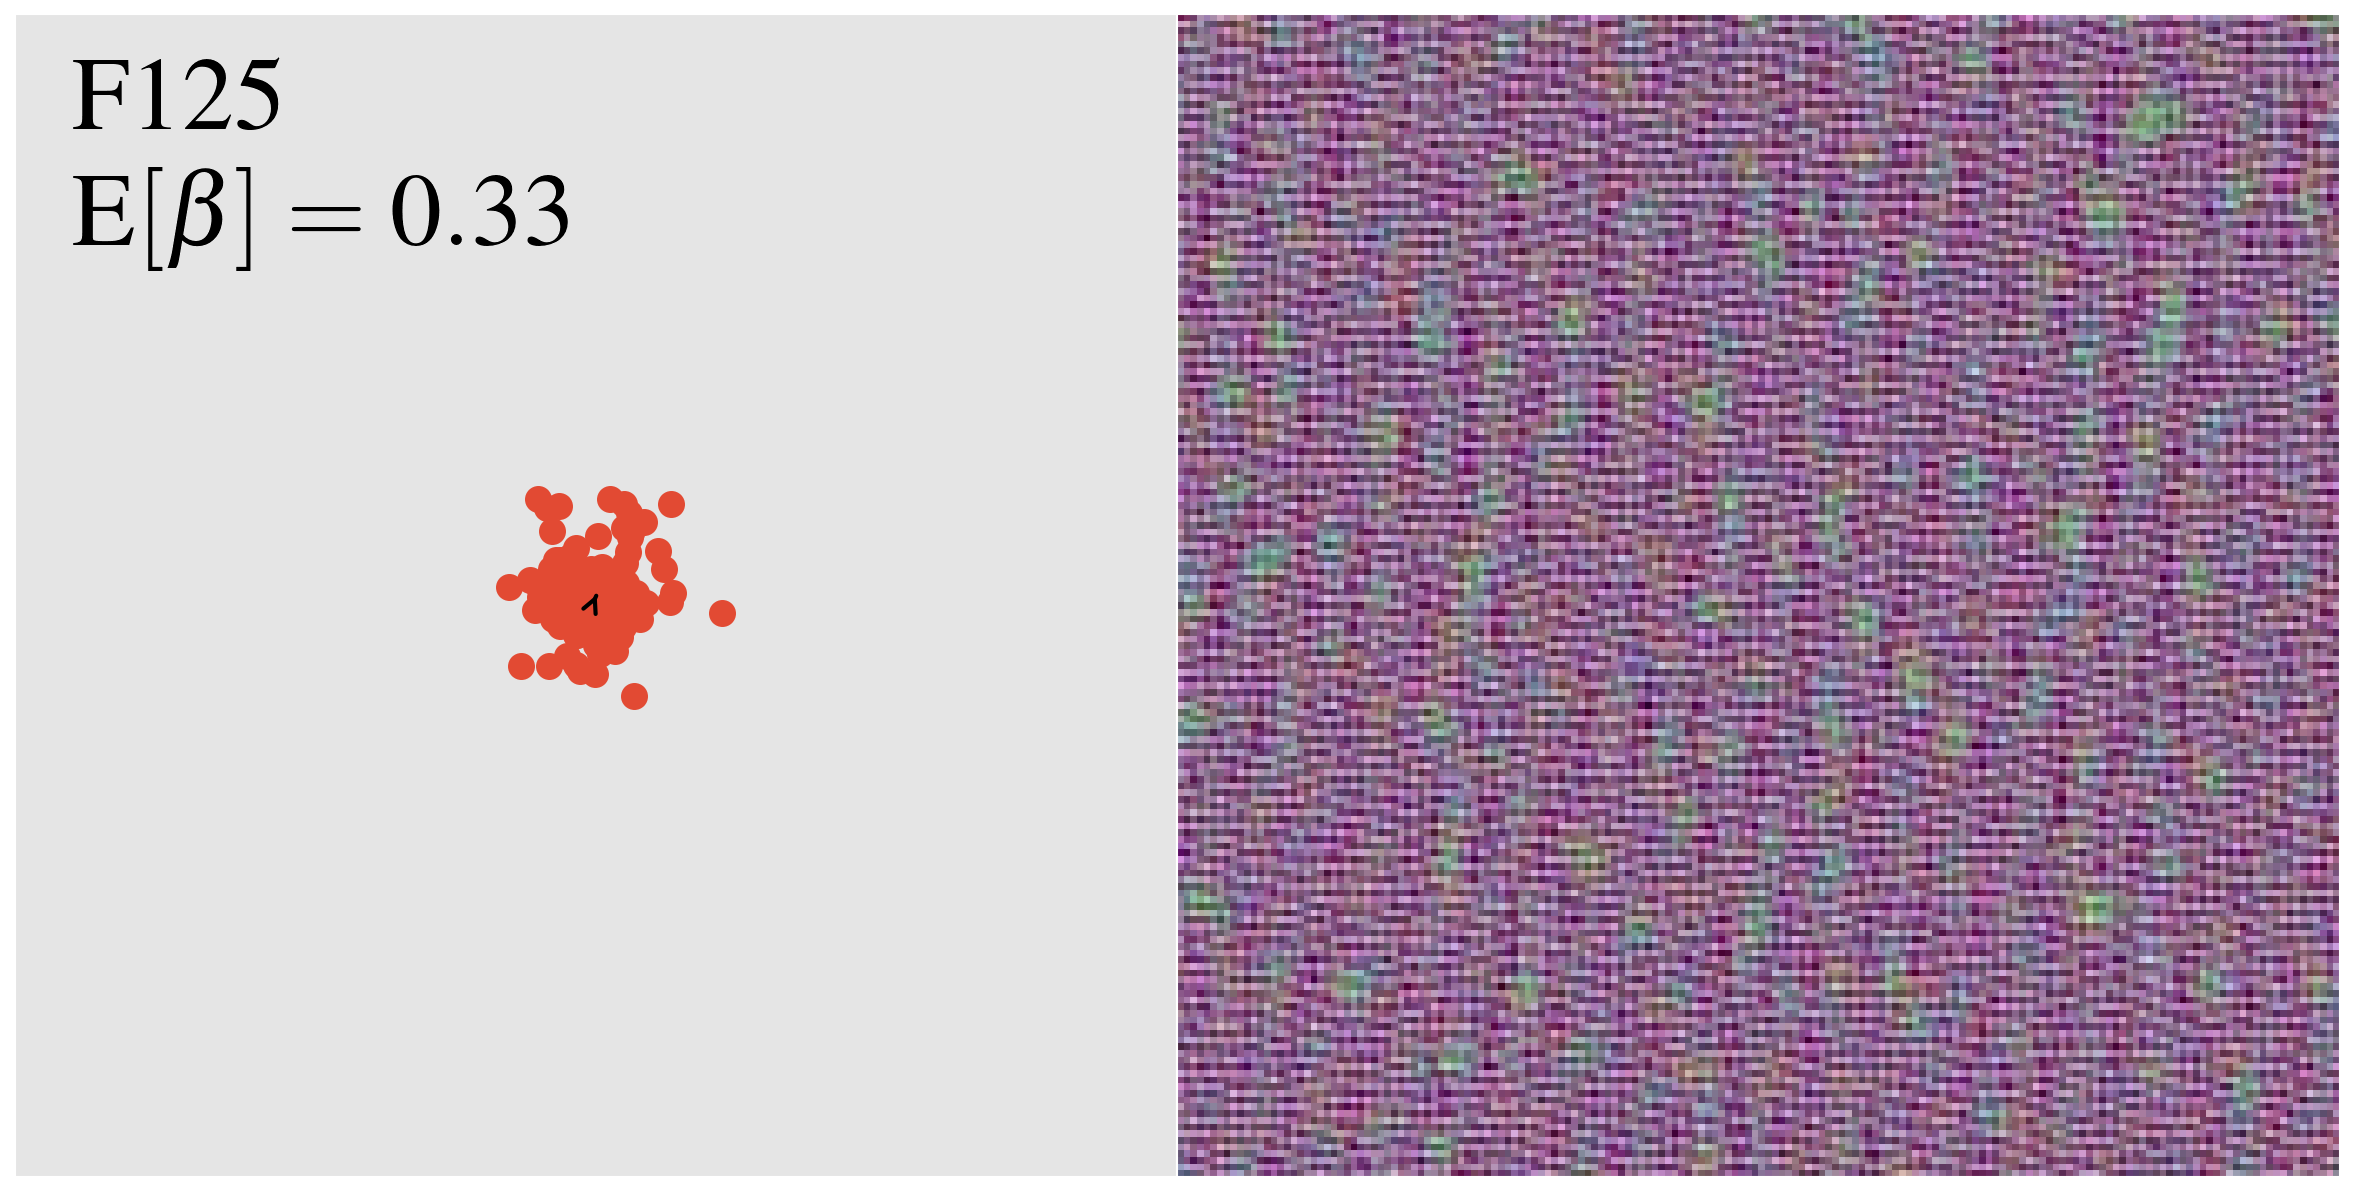

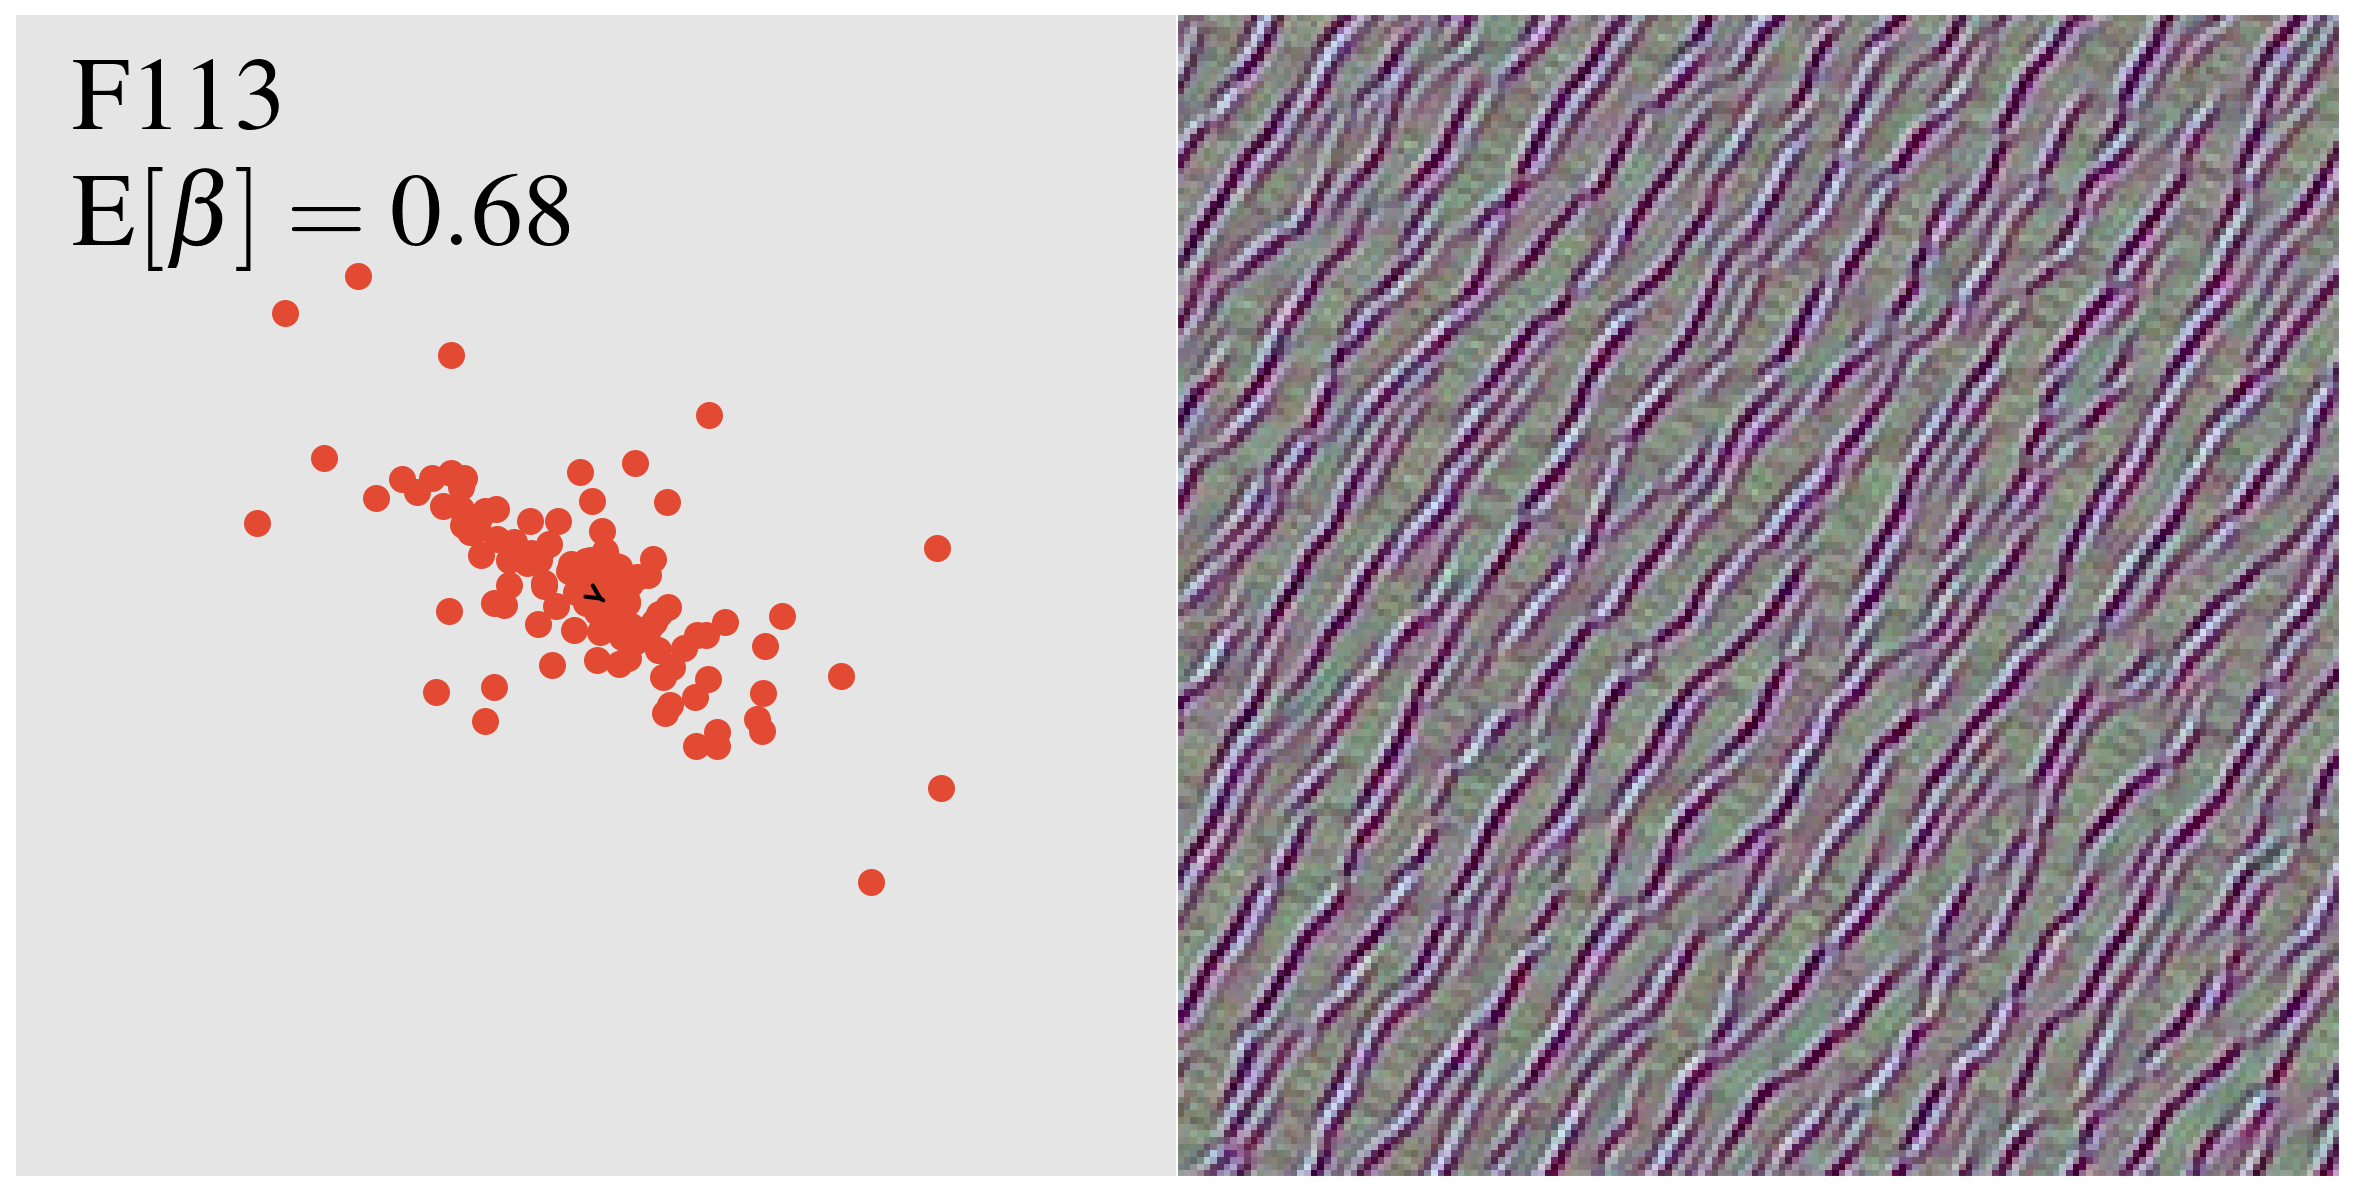

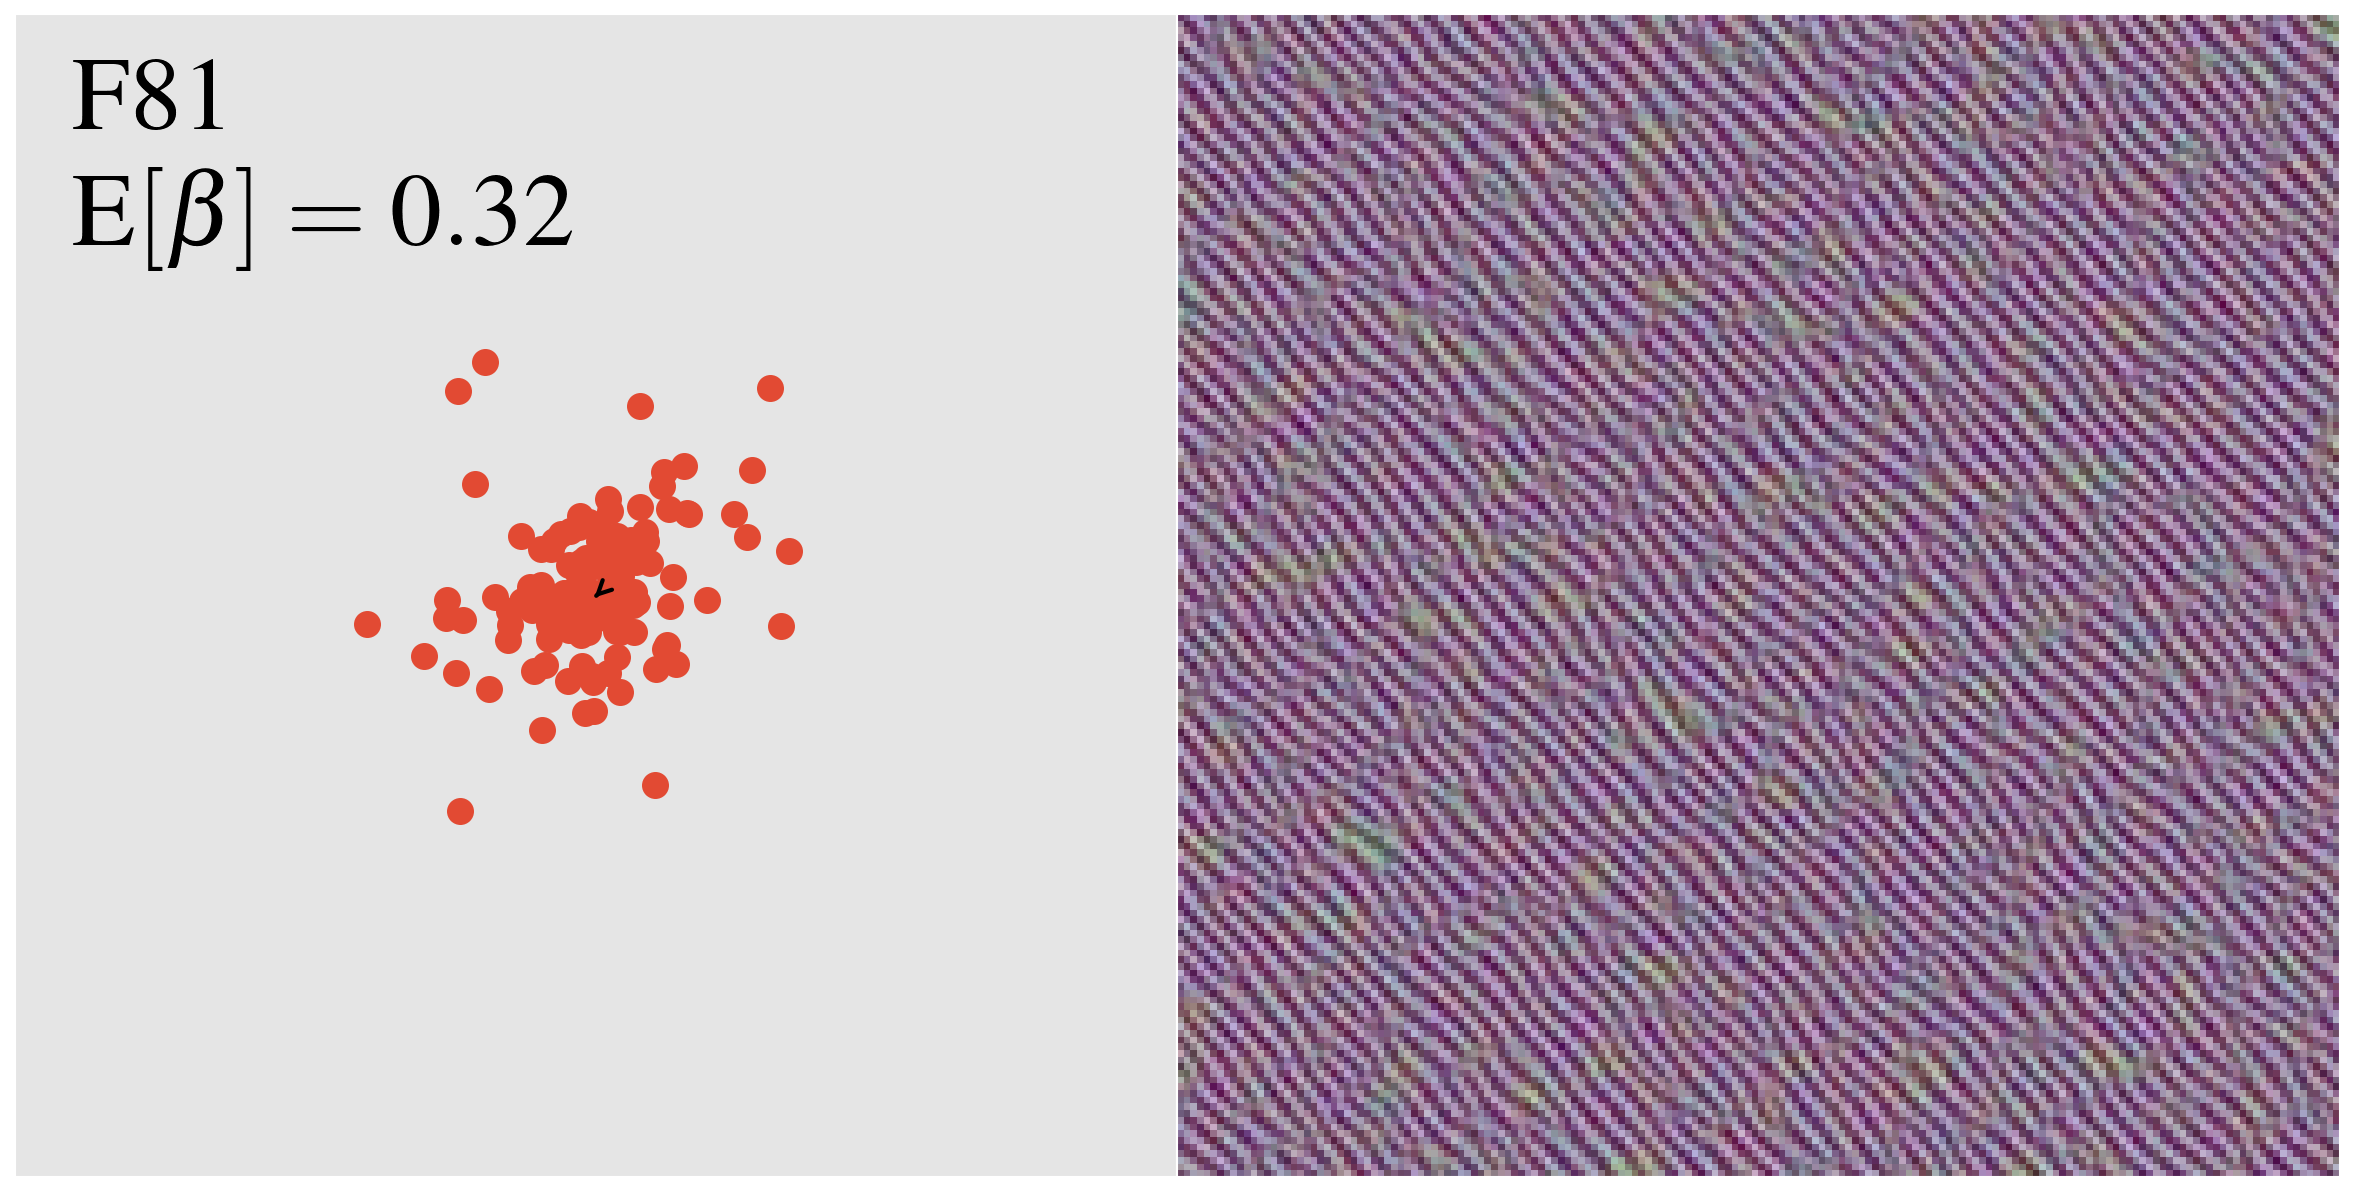

In [6]:
plt.rcParams.update({'figure.dpi': '300'})

plt.rcParams["axes.facecolor"] = "E5E5E5"
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["text.usetex"] =  True
#[101, 105, 10, 41, 12, 14, 16, 113, 18, 19]
model = VGG16(weights='imagenet',
				  include_top=False,
				  input_shape=(224, 224, 3))

LAYER =4
F = 252 #19 101  14  16
prune = True

conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		conv_layers.append(l)

top = np.array([7,8,105]) 

directory = f"figures/AM_{LAYER}_{F}"
if not os.path.exists(directory):
	os.makedirs(directory)

f = open(f"{directory}/diagram_{LAYER}_{F}.tex", "w+")
f.write(f'''\\documentclass{{standalone}}
	\\usepackage{{tikz}}
		\\graphicspath{{ {{{directory}/}} }}
	\\begin{{document}}\n''')
f.write("\\begin{tikzpicture}[node distance=0.01cm and 3cm]\n ")



# Take a filter, and find the top connections to it (top channels that connect to top filters in the previous layer)
#### UNCOMMENT THIS !!!!!######
prv_top10KF = topKfilters(model, LAYER-1, k=20)
top_k_connections = np.array(list(set(prv_top10KF).intersection((topKchannels(model,LAYER,F, k=20)))))
print("Topk", top_k_connections)
#prv_filters = get_filter(model, LAYER-1)[:,:,:, top_k_connections]
ch_mag = reduce_euclidean_norm(get_filter(model, LAYER)[:,:,top_k_connections, F], axis=[0,1])**2
idx = list(range(ch_mag.shape[-1]))
idx = [x for _, x in sorted(zip( ch_mag, idx), reverse=True)]
print(top_k_connections[idx])
top_k_connections = top_k_connections[idx][:5]

if prune:
	w,b = model.get_layer(conv_layers[LAYER].name).get_weights()

	#top_k_connections = [  56 ]
	mask = np.ones(w.shape, bool)
	mask[: ,:, top_k_connections, :] = False
	w[mask] = 0
	mask = np.ones(b.shape, bool)
	mask[top_k_connections] = False
	b[mask] = 0
	model.get_layer(conv_layers[LAYER].name).set_weights([w,b] )


'''filtersLp = get_filter(model, LAYER-1)
domThetaP = getDominantAngle(filtersLp)
filtersL = get_filter(model, LAYER)
s, a = getSymAntiSymTF(filtersL)
a_mag = reduce_euclidean_norm(a, axis=[0,1])[:, F]
thetaL = getSobelTF(filtersL)[:, F]

s, a = getSymAntiSymTF(filtersLp)
a_magLp = reduce_mean(reduce_euclidean_norm(a, axis=[0,1]), axis=0)	
malus = a_magLp*a_mag*(np.cos(domThetaP-thetaL )**2+9)/10
top_k_connections = np.argsort(malus, axis=0)[-15:]'''

f.write(f'''\\node[anchor=center] (0) at (0,-0.8) {{ {LAYER} \\ ({conv_layers[LAYER-1].name.replace("_", chr(92)+"_")}) }};\n''')
f.write(f'''\\node[anchor=center] at (5,-0.8) {{ {LAYER+1} \\ ({conv_layers[LAYER].name.replace("_", chr(92)+"_")}) }};\n ''')


f.write(f'''\\foreach \label [count=\\i] in {{{','.join([f"L{LAYER-1}_F{c}.png" for c in top_k_connections])}}} {{ \n 
	\\node[draw=none] (\i) at (0,-\i*6em) {{\includegraphics[width=0.3\\textwidth]{{\label}} }}; \n  }}\n''')

r_pos = (len(top_k_connections) // 2)+1 if len(top_k_connections)%2 else (len(top_k_connections) / 2) +0.5
f.write(f"\\node[] (R) at (5,-{r_pos}*6em) {{\includegraphics[width=0.3\\textwidth]{{ {f'L{LAYER}_F{F}.png'} }} }}; % Adjust the y-coordinate to center\n")

fig, ax= plt.subplots(1,2,figsize = (10,13))
beta, theta = plotAntiPlane(model, LAYER, F,  ax[0], plot=top_k_connections)
origAM, scaledAM = getAM(model, LAYER, F )
ax[1].imshow(scaledAM);
ax[1].set_aspect('equal')
ax[0].set_aspect('equal')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
fig.subplots_adjust(wspace=0, hspace=0)
ax[0].text(.05, .78, f"F{F}\n"+r'$\text{E}[\beta]='+f"{beta:.2f}"+r"$", fontsize=25,
		horizontalalignment='left',
		verticalalignment='bottom',
		transform=ax[0].transAxes);
plt.savefig(f"{directory}/L{LAYER}_F{F}.png",bbox_inches='tight', pad_inches = 0, dpi=200);

sign = []
betaF = []
betaC = []
thetaC = []
thetaF = []
for c in top_k_connections:
	
	fig, ax= plt.subplots(1,2,figsize = (10,13))
	b, t = plotAntiPlane(model, LAYER-1, c,  ax[0])
	betaF.append(b)
	thetaF.append(t)
	origAM, scaledAM = getAM(model, LAYER-1, c )
	ax[1].imshow(scaledAM);
	ax[1].set_aspect('equal')
	ax[0].set_aspect('equal')
	ax[0].set_xticks([])
	ax[1].set_xticks([])
	ax[0].set_yticks([])
	ax[1].set_yticks([])
	fig.subplots_adjust(wspace=0, hspace=0)
	
	filters = get_filter(model, LAYER)
	s, a = getSymAntiSymTF(filters)
	a_mag = reduce_euclidean_norm(a[:,:,c, F], axis=[0,1])
	s_mag = reduce_euclidean_norm(s[:,:,c, F], axis=[0,1])

	betaC.append((a_mag**2)/(a_mag**2 + s_mag**2))
	thetaC.append(getSobelTF(filters)[c, F])
	print(thetaF[-1], thetaC[-1])
	if(np.mean(get_filter(model, LAYER)[:,:,c, F]) < 0.):
		sign.append('n')
	else:
		sign.append('p')
	ax[0].text(.05, .78, f"F{c}\n"+r'$\text{E}[\beta]='+f"{betaF[-1]:.2f}"+r"$", fontsize=25,
	horizontalalignment='left',
	verticalalignment='bottom',
	transform=ax[0].transAxes);
	plt.savefig(f"{directory}/L{LAYER-1}_F{c}.png",bbox_inches='tight', pad_inches = 0, dpi=200);


for i in range(len(top_k_connections)):
	if betaC[i]<0.5:	
		if sign[i]=='n':
			f.write(f''' \draw ({i+1}.east) -- (R) node[pos=0.5, circle, draw, fill=white, minimum size=8pt, inner sep=0pt, scale=0.8] {{$-$}}; \n''')

		else:
			f.write(f''' \draw ({i+1}.east) -- (R) node[pos=0.5, circle, draw, fill=white, minimum size=8pt, inner sep=0pt, scale=0.8] {{$+$}}; \n''')

	else:	
		cosSim = np.cos(thetaC[i] - thetaF[i] )
		cosSim = f"{cosSim:.1f}"
		if cosSim == "-0.0":
			cosSim="0.0"

		f.write(f''' \draw ({i+1}.east) -- (R) node[pos=0.5, circle, draw, fill=white, minimum size=8pt, inner sep=0pt, scale=0.5] {{ {cosSim} }}; \n''')



f.write("\end{tikzpicture}\n")
f.write("\end{document}\n")

f.close()

import subprocess
subprocess.run(["pdflatex", f"{directory}/diagram_{LAYER}_{F}.tex"]) 
#subprocess.run(["convert" "-density" "300" 'diagram.pdf' '-quality' '600' f"AM_{LAYER}_{F}.png"])


In [7]:
w[:,:,:,F]

array([[[ 0.        ,  0.        ,  0.        , ..., -0.0544626 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.00557851,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.04689633,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ..., -0.06634418,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.00369239,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.06248766,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ..., -0.0391729 ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ..., -0.00411426,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.04343028,
          0.        ,  0.        ]]], dtype=float32)

In [8]:
filter_activation

NameError: name 'filter_activation' is not defined

In [ ]:
model2 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=( 174, 174, 3))
conv_layers = []
for l in model2.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)

layer = conv_layers[1]

f = K.function([model2.input], [layer.output])
#origAM = origAM[25:-25, 25:-25, :]
filter_activation = f(tf.expand_dims(np.rot90(origAM, axes= [0,1], k=1), 0))[0][0,:,:,19]
print(filter_activation.shape)
filter_activation =  filter_activation

heatmap = cv2.resize(filter_activation, (scaledAM.shape[0], scaledAM.shape[1]))
# Normalize the heatmap between 0 and 1 for visualization
#heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# Apply the heatmap to the input image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.flip(scaledAM, axis=-1), 0.7, heatmap, 0.3, 0)

# Display the result
plt.imshow(filter_activation)
plt.axis('off')
plt.colorbar()

plt.show()



In [ ]:
plt.imshow(np.flip(superimposed_img, axis=-1))
plt.axis('off')
plt.show()

